In [2]:
import numpy as np
import pandas as pd

import strawb
import strawb.sensors.camera as camera
import os
import matplotlib.pyplot as plt

# Load files from the ONC server
Be careful, depending on the amount of data this can take a while!!

In [3]:
# load DB
db = strawb.SyncDBHandler(file_name='Default')  # loads the db
db.load_onc_db_update(save_db=True)  # update the DB, could take some time if it has to load info. from ONC

Print some info from the DB

In [4]:
print(db.dataframe.columns)

### these are the available device codes
print(db.dataframe.deviceCode.unique())

### different measurement types for PMTSPEC and LIDAR, 
# works only if hdf5 attributes are imported from files on disc
#print(db.dataframe.measurement_type.unique())

### these are the parts of each module that produce data
print(db.dataframe.dataProductCode.unique())

Index([     'archiveLocation',         'archivedDate',          'compression',
            'dataProductCode',             'dateFrom',               'dateTo',
                 'deviceCode',             'fileSize',             'filename',
                 'modifyDate',                 'path', 'uncompressedFileSize',
                    'outPath',             'fullPath',               'synced',
                   'h5_attrs',             'dev_code',             'file_end',
                    'file_id',           'file_start',    'following_file_id',
                       'name',     'previous_file_id',    'rollover_interval',
                    'run_end',            'run_start',         'write_period',
               'file_version',                      0],
      dtype='object')
['ONCMJB016' 'TUMLIDAR001' 'TUMLIDAR002' 'TUMMINISPECTROMETER001'
 'TUMMUONTRACKER001' 'TUMPMTSPECTROMETER001' 'TUMPMTSPECTROMETER002'
 'TUMSTANDARDMODULE001' 'TUMSTANDARDMODULE004']
['LF' 'PMTSD' 'SMRD' 'MSRD' 

### Select (a) file(s) of interest

In [5]:
mask = (db.dataframe.deviceCode == 'TUMPMTSPECTROMETER001') # that's the pmtspec module
mask &= (db.dataframe.dataProductCode =='MSSCD') # that's the camera data of the pmtspec module

## select the file for the biolumi event
timestamp = pd.Timestamp('2021-09-04T23:44:09').tz_localize('UTC')
mask &= db.dataframe.dateFrom <= timestamp 
mask &= db.dataframe.dateTo >= timestamp

### selected one file from the DB (it's the same as the file we selected above by hand)
db.dataframe[mask]

,archiveLocation,archivedDate,compression,dataProductCode,dateFrom,dateTo,deviceCode,fileSize,filename,modifyDate,...,file_start,following_file_id,name,previous_file_id,rollover_interval,run_end,run_start,write_period,file_version,0
fullPath,,,,,,,,,,,,,,,,,,,,,
/Users/kilian/vscode/strawb_package/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210904T230000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_04,2021-09-05 01:51:24.463000+00:00,None,MSSCD,2021-09-04 23:00:00+00:00,2021-09-04 23:59:59.999000+00:00,TUMPMTSPECTROMETER001,58043955,TUMPMTSPECTROMETER001_20210904T230000.000Z-SDA...,2021-09-05 01:51:26.475000+00:00,...,NaT,NaN,NaN,NaN,None,NaT,NaT,NaN,1.0,"{'dev_code': 'TUMPMTSPECTROMETER001', 'file_en..."


### Download the missing files which aren't synced so far from `db.dataframe[mask]`

In [6]:
if not db.dataframe.synced[mask].all():
    db.update_db_and_load_files(
        db.dataframe[mask],
        output=True,  # print output to console
        download=True,  # download the files
        save_db=True,
    )  # update the DB

# Import the file to the Camera Module 

In [7]:
# select the filename
file_name = db.dataframe.fullPath[mask].iloc[-1]
print(file_name)

# create an instance of the Camera
camera = strawb.sensors.camera.Camera(file_name)

/Users/kilian/vscode/strawb_package/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210904T230000.000Z-SDAQ-CAMERA.hdf5


### Print some parameters

In [8]:
print(f'Module: {camera.file_handler.module}')
print(f'Number of Frames: {camera.file_handler.exposure_time.shape[0]}')
print(f'Date: {np.min(camera.file_handler.time.asdatetime()[:])} - {np.max(camera.file_handler.time.asdatetime()[:])}')
print(f'Exposure Times [s]: {np.unique(camera.file_handler.exposure_time)}')

Module: TUMPMTSPECTROMETER001
Number of Frames: 36
Date: 2021-09-04T22:59:18.344365 - 2021-09-04T23:57:27.277572
Exposure Times [s]: [52.5]


### Mask images to export (here only one)

In [9]:
# mask over a threshold + mask invalid frames + mask no lucifer enabled
mask = (camera.images.integrated_minus_dark > 1e6) & camera.images.invalid_mask

index = np.argsort(camera.images.integrated_minus_dark)  # sort by charge [min,...,max]
index = index[mask[index]]  # remove invalid items  & cam_module.invalid_mask
index = index[::-1]  # revers the order
print(index)

[27]


## Export the image as png and store it on disc

In [20]:
camera.images.image2png(
    index=index, 
    directory="./figures", # add your preferred dir here
    f_name_formatter='bright_test_pic_{i}_{datetime}.png')  # save the images

['/Users/kilian/vscode/strawb_package/examples/figures/bright_test_pic_0_2021_09_04_23_44_09.png']

In [13]:
np.uint16

numpy.uint16

## Show one image here

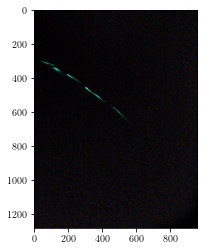

In [14]:
plt.figure()
rgb = camera.images.load_rgb(index=index)
plt.imshow(rgb[0,:,:]/2**16)  # rgb[frame, row, col], /255 to get 0->1
plt.savefig("figures/biolumi_demo.pdf", backend="pdf")
plt.savefig("figures/biolumi_demo.png", dpi=120)

## How to access the raw data (numpy)

In [22]:
# The raw pixel values are NOT loaded by default to the module to save RAM.
# They can be accessed directly from the file with the index, index = None (default) to loads all images
a = camera.file_handler.raw[[1,3]]  # direct h5py access, allows only sorted (non-duplicate) index access.
print(a.shape)

a = camera.file_handler.raw.getunsorted([1,3])  # STRAWb helper to access it unsorted (and duplicate) by index
print(a.shape)

a = camera.file_handler.raw[:]  # get all images
print(a[0]) # returns array on default, even if only one element is accessed
print(a[0].shape) # 2D shape of picture
print(a.shape) # n_pic x 2D shape of picture

(2, 1297, 977)
(2, 1297, 977)
[[    0     0  6128 ... 19248 28208 17968]
 [    0     0     0 ... 22448 14768 22288]
 [ 2128     0    48 ... 23568 28048 21648]
 ...
 [65504 65504 65504 ... 65504 65504 65504]
 [65504 65504 56848 ... 65504 65504 65504]
 [58928 65504 59248 ... 65504 65504 65504]]
(1297, 977)
(36, 1297, 977)


In [ ]:
plt.figure()

plt.plot(raw[])

In [10]:
camera.images.

AttributeError: 'Images' object has no attribute '_rgb'